# Spectral analysis example 

## MBARI data from Elkhorn Slough 

To demonstrate how the Fourier transform can be calculated numerically to create a power spectrum, we use data from the Land Ocean Biogeochemical Observatory in Elkhorn Slough. The data come from the L01 buoy just up channel from the Highway 1 bridge. This buoy is maintained by Dr. Ken Johnson's Chemical Sensors group at MBARI, which develops new technology in order to understand high-frequency fluctuations in biogeochemical parameters over long time periods.

![images/loboarray_small.jpg](images/loboarray_small.jpg)

The data can be downloaded in text format at this site:
http://www3.mbari.org/lobo/getLOBOdata.htm

## Loading the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

filename = 'data/MBARI_LOBO/L01SURF_subset.txt'
data = np.genfromtxt(filename,delimiter=',',skip_header=3)

After loading the data, missing values are replaced with NaNs and three variables are created from the larger data set: time (days since 1/1/1900), nitrate ($\mu$M) and water depth (m). These data are a small continuous subset of the multi-year time series from 1 January - 22 March 2007.

In [2]:
flagi = np.where(data>1E100)
data[flagi] = np.nan

time = data[:,1]
nitrate = data[:,2]
waterdep = data[:,3]

## Plotting the data

First, it is always helpful to plot the data in the time domain to get a visual sense of the variability. The data set is about 80 days long. The water depth plot primarily shows the tides, which have a fortnightly spring-neap cycle. The nitrate data also show high-frequency variability due to the tides, but there are also irregular pulses of high nitate. This is the winter season, and freshwater runoff from storms can have very high nitrate concentrations because of of all the agriculture in the watershed.

Text(0.5, 1.0, 'nitrate [$\\mu$M]')

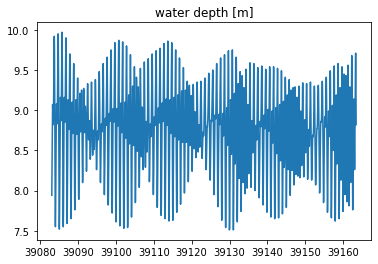

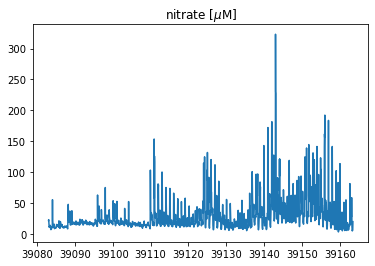

In [3]:
plt.figure()
plt.plot(time,waterdep)
plt.title('water depth [m]')

plt.figure()
plt.plot(time,nitrate)
plt.title('nitrate [$\mu$M]')

## Discrete Fourier Transform

Now we calculate the Fourier transform of the data. Because we are using a finite number of data points, this is a discrete Fourier transform (DFT). 

We start with $N$ data points in a time series $y_n = [y_0,y_1,y_2,...,y_{N-1}]$. The discrete Fourier transform will consist of $N$ values $Y_k  = [Y_0,Y_1,Y_2,...,Y_{N-1}]$. These values are complex, with a real part and imaginary part, 

$Y_k = (\alpha_k +i \beta_k)$.

The values of the discrete Fourier transform in Python correspond to this equation:

$Y_k = \sum^{N-1}_{n=0}{y_n}\exp{\left(-i2 \pi \frac{kn}{N} \right)}$

The original time series values can be reconstructed from these values using the inverse Fourier transform:

$y_n = \frac{1}{N}\sum^{N-1}_{n=0}{Y_k}\exp{\left(i2 \pi \frac{kn}{N} \right)}$

The meaning of these equations is explained in more detail below using the LOBO dataset as an example. Sometimes these equations are scaled differently, for example, with $1/N$ in front of the Fourier transform instaead of its inverse transform. These equations show the particular form used in Python, but can be different if you are programming in MATLAB. The important thing is that the form is documented, and that the inverse gets you back the original time series.

## Fast Fourier Transform alogorithm

The DFT is computed numerically using the Fast Fourier Transform (FFT) algorithm, developed by Cooley and Tukey in 1965$^1$. The intuitive (slow) algorithm for fitting sines and cosines to the data and calculating the coeffiecients involves $O(N^2)$ operations, where $N$ is the number of data points. The Cooley and Tukey FFT alogorithm involves $O(N\log(N))$ operations, which is a huge imporovement.

$^1$ Actually, Carl Friedrich Gauss discovered this algorithm in 1805 and used it to analyze asteroid trajectories. However, he apparently did not realize the full implications of his algorithm on computional cost, even though he was doing his computations by hand. Cooley and Tukey discovered the same algorithm independently and studied its impacts on computational efficiency. (source: [Wikipedia](https://en.wikipedia.org/wiki/Cooley%E2%80%93Tukey_FFT_algorithm))

Here is how we compute the DFT of the water depth time series in Python, using the FFT algorithm:

In [13]:
wd_fft = np.fft.fft(waterdep)

That wasn't too hard! This function wraps the complexity of the FFT numerical algorithm into a simple command. But, we still have to understand the discrete Fourier transform in order to interpret the output.

Note that the length of the DFT output array is the same length as the orginal data array.

In [14]:
N = len(waterdep)
print('number of values in time series = ',N)
print('number of values in discrete Fourier transform = ',len(wd_fft))

number of values in time series =  1932
number of values in discrete Fourier transform =  1932


However, it is important to remember that the DFT coefficients are *complex-valued*, that is, they have a real and imaginary part. Lets look at the first five values:

In [15]:
print(wd_fft[0:5])

[ 1.69295600e+04 +0.j         -1.27189536e+01-59.52415828j
  1.98163773e+01 +0.61386253j  5.67021868e+00-15.44332206j
  6.61725082e+00 -4.52031655j]


To visualize all of the Fourier coefficients, we can plot both the real and imaginary parts. These complex-valued coefficients contain information about the *magnitude* and *phase* of the sines and cosines that are fit to the data at each frequency.

Text(0, 0.5, '[m]')

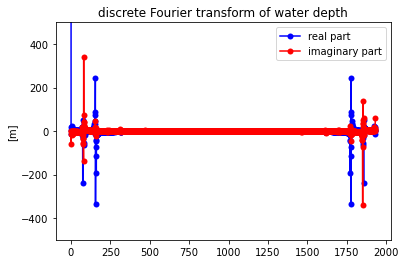

In [16]:
plt.figure()
plt.plot(np.real(wd_fft),'b-o',markeredgecolor='none')
plt.plot(np.imag(wd_fft),'r-o',markeredgecolor='none')
plt.ylim([-500,500])
plt.legend(['real part','imaginary part'],loc='best')
plt.title('discrete Fourier transform of water depth')
plt.ylabel('[m]')

The FFT function does not automatically tell us which frequencies correspond with these coefficients. They are ordered in a very specific manner. 

* The first coefficient in the array (index 0) is the coefficient for the *zero* frequency. In other words, it is a constant. It has no imaginary part, which can be seen in the first few values of the output array printed above.
* The next N/2 values in the array are the coefficients for positive frequencies. The second value in the array (index 1) correspeonds to the fundamental frequency. The middle value in the array (index N/2) corresponds to the Nyquist frequency.
* The values in the second half of the array correspond to negative frequencies. The last value in the array (index N-1) corresponds to the negative fundamental frequency. The coefficients for the Nyquist frequency are shared between the positive and negative frequencies.

Note that the coefficients for fitting sines and cosines to a time series do not necessarily have to be ordered in the particular way, nor do they need to be expressed as complex numbers. However, this is the standard practice that has evolved over a rich history of mathematically transforming between the time and frequency domains starting with Fourier.

The results are easier to understand if we use the `np.fft.fftfreq` function to obtain the corresponding frequencies, then plot the real and imaginary parts of the coefficients as a function of frequency.

Text(0.5, 1.0, 'discrete Fourier transform of water depth \n lower frequencies, positive and negative')

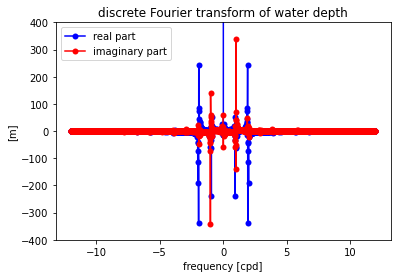

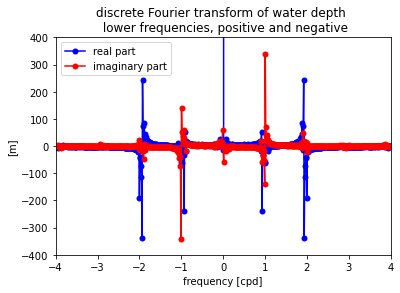

In [17]:
deltat = 1/24
f = np.fft.fftfreq(N,deltat)

plt.figure()
plt.plot(f,np.real(wd_fft),'b-o',markeredgecolor='none')
plt.plot(f,np.imag(wd_fft),'r-o',markeredgecolor='none')
plt.ylim([-400,400])
plt.legend(['real part','imaginary part'],loc='upper left')
plt.xlabel('frequency [cpd]')
plt.ylabel('[m]')
plt.title('discrete Fourier transform of water depth')

plt.figure()
plt.plot(f,np.real(wd_fft),'b-o',markeredgecolor='none')
plt.plot(f,np.imag(wd_fft),'r-o',markeredgecolor='none')
plt.ylim([-400,400])
plt.xlim([-4,4])
plt.legend(['real part','imaginary part'],loc='upper left')
plt.xlabel('frequency [cpd]')
plt.ylabel('[m]')
plt.title('discrete Fourier transform of water depth \n lower frequencies, positive and negative')

Looking at just the lower frequencies that dominate the variance in the data, several patterns become more clear. 

* The zero frequency coefficient is really big (off the scale). It is usually best to remove the mean of the time series before taking the FFT to avoid a large value of this constant, as well as potential round-off errors.

* Most of the coefficients are close to zero, except at positive and neagtive frequencies around 1 cpd and 2 cpd. These frequencies correspond to the dominant tides.

* There is symmetry between the positive and negative coefficients. The real parts are mirror images of each other. The imaginary parts are equal but opposite.

This type of symmetry is refered to as *Hermitian*. For each complex coefficient $Y_k = (\alpha_k + \beta_k i)$ at a positive frequency $f_k$, the coefficient for the negative of that frequency $-f_k$ is the *complex conjugate* $Y_k^* = (\alpha_k - \beta_k i)$.

What are these negative frequencies? They are what you would get if you flipped the time series around before fitting sines and cosines. Because the cosine function $\cos(t)$ is a mirror image of itself for positive and negative times, you get the same answer for a negative frequency (going backward in time) as you do for a positive frequncy (going forward in time). In a sine function $\sin(t)$, the values for negative times are the negative of the values for positive times.

The output will always be Hermitian as long as all of the input values are real. The symmetry breaks down if the input values are complex. Complex values are sometimes used to represent vectors, like current velocities. We will only briefly touch on the analysis of complex vectors in this course.

If the inputs are real, like the scalar values of water depth that we are analyzing here, then it is clear that the coefficients for positive and negative frequencies are redundant. If we have $N$ real input values in the time domain, we get independent $N$ numbers representing the same time series in the frequency domain (some real, some imaginary).

## Power spectrum

The discrete Fourier transform gives information about the magnitude and phase of sine and cosine waves at different frequencies that contribute to the overall signal. The information in the DFT can be used to completely reconstruct the orininal signal in the time domain. However, often we are most interested in the magnitude, rather than phase (or timing) of the different components. The power spectrum $S_k(f)$ is a common way of expressing the magnitude of the components at different frequencies.

$$ 
\begin{aligned}
S_k(f) &= \frac{2\Delta t}{N} \left| Y_k \right| \\
       &= \frac{\Delta t}{N} \left( \alpha_k^2 + \beta_k^2 \right)
\end{aligned}
$$

In [18]:
S = (2/N)*deltat*np.abs(wd_fft)**2 

The scaling factor ($2 \Delta t /N$) is chosen so that the integral of $S_k$ over all of the different frequencies $f_k$  is equal to the variance of the original signal. Each value in the power spectrum can be thought of as the contribution of the component at that specific frequency to the total variance in the time series,

$$ \sigma^2_{y, tot} = \sum^{N/2}_{k=0} S_k \Delta f, $$

where $\Delta f = f_f$ is the difference between frequencies, which is equal to the fundamental frequency.

The power spectrum is plotted on a log-log scale to help visualize the different components. We will also see later that plotting on a log scale simplifies the plotting of confidence intervals to distinguish statistically significant peaks in the spectrum. 

The values of $S_k$ describe the *power spectral density* (PSD). The values have units of the original units of the time series squared, divided by the units of frequency. In this case, the original units for the time series of water depth are in meters and we are using cpd for the units of frequency, so the PSD units are m$^2$/cpd.

This type of plot is also called a *periodogram*.

Text(0.5, 1.0, 'water level periodogram')

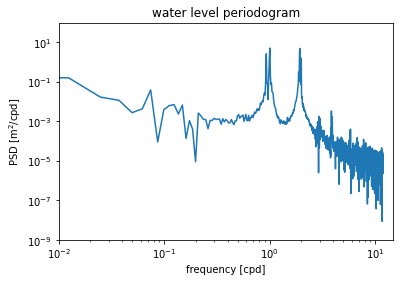

In [19]:
plt.figure()
plt.loglog(f[0:round(N/2)],S[0:round(N/2)])
plt.xlabel('frequency [cpd]')
plt.ylabel('PSD [m$^2$/cpd]')
plt.ylim([1e-9,1e2])
plt.xlim([1e-2,1.5e1])
plt.title('water level periodogram')

The power spectrum shows peaks near the 1 cpd and 2 cpd frequencies. Again, these correspond to the dominant tidal constituents that contribute to variance in water level. 

Zooming in and looking more closely at these peaks shows that there are actually several different peaks near the 1 cpd and 2 cpd frequencies. This is to be expected from the combination of tidal forces due to the sun and moon.

The frequency resolution (how finely spaced the different frequencies are on the horizontal axis) is determined by the record length $T$. The fundamental frequency is $f_f = 1/T$. The rest of the frequencies are harmonics, or multiples, of this frequency: $1/T,2/T, 3/T, 4/T,...,N/(2T)$. A longer record length means that $1/T$ is smaller and this set of frequencies is more finely spaced. The point is, we can only distinguish between these tidal constituents with slightly different frequencies because we have a long record length (about 80 days).

Text(0.5, 1.0, 'water level periodogram')

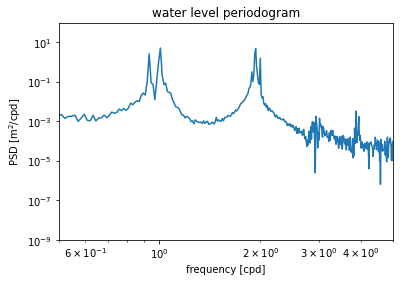

In [20]:
plt.figure()
plt.loglog(f[0:round(N/2)],S[0:round(N/2)])
plt.xlabel('frequency [cpd]')
plt.ylabel('PSD [m$^2$/cpd]')
plt.ylim([1e-9,1e2])
plt.xlim([5e-1,5e0])
plt.title('water level periodogram')

### Alternative method (the easy way)

The steps above are meant to illustrate how the periodogram is connected to the discrete Fourier transform of the data. The signal processing library of SciPy includes a function that makes it much easier to compute the periodogram directly. It is called `periodogram`.

The `fs` argument is the sampling frequency (you can use whatever units you want as long as the value is consistent with the data. This function returns the frequency array (positive values only) and the corresponding PSD array. The values correspond exactly with those found above.

Text(0.5, 1.0, 'water level periodogram')

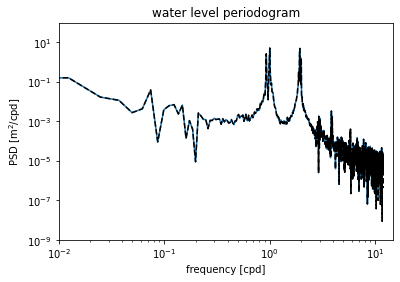

In [21]:
from scipy.signal import periodogram

fp,Sp = periodogram(waterdep,fs=24.)

plt.figure()
plt.loglog(f[0:round(N/2)],S[0:round(N/2)])
plt.loglog(fp,Sp,'k--')
plt.xlabel('frequency [cpd]')
plt.ylabel('PSD [m$^2$/cpd]')
plt.ylim([1e-9,1e2])
plt.xlim([1e-2,1.5e1])
plt.title('water level periodogram')

## Exercises

* Compute the periodogram for the LOBO nitrate data. Label the y-axis with the correct units. Compare the spectrum with that of the water level spectrum. What are some similarities and differences? 

## Critique

Although we have succussfully plotted the periodogram of the data, there are two major issues with the *raw* periodogram as we calculated above straight from the FFT results.

1) It is noisy (random error)

2) It is biased (systematic error)

Although this method is very useful for describing practical Fourier analysis conceptually, there are issues with it in practice. These problems led John W. Tukey (co-inventor of the FFT) to remark on the perils of using this method quantitatively:

>"More lives have been lost looking at the raw periodogram than by any other action involving time series."

In [Part 2](week10b_lobo_spectral_part2.ipynb) of this tutorial, we will expand on this basic method to show ways of improving on this basic method of computing the power spectrum.